<a href="https://colab.research.google.com/github/ErrorLogic1211/Skin-Cancer-classifer/blob/main/Skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.applications.mobilenet import MobileNet

from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, save_img
from tensorflow.python.keras.layers import Dense, Flatten,MaxPooling2D, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from keras.utils.vis_utils import plot_model

In [ ]:
train_data_dir='E:\\data\\train'
test_data_dir='E:\\data\\test'

img_height= 224
img_width = 224
batch_size= 64




train_datagen = ImageDataGenerator(rescale=1./255,
    zoom_range=0.1,
    validation_split=0.1) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    ) # set as validation data

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,  
        target_size=(img_height,img_width), 
        batch_size=batch_size,  
        class_mode='binary',
        shuffle=False)


(224, 224, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

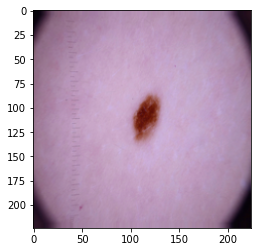

In [ ]:
x,y=next(train_generator)
print(x[0].shape)
plt.imshow(x[0,:,:,:])
plt.show

In [ ]:
epochs= 30
model = Sequential()

pretrained_model= InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
print(len(pretrained_model.layers))
# if we want to set the first  layers of the network to be non-trainable
#for layer in pretrained_model.layers[:len(pretrained_model.layers)-2]:
   # layer.trainable=False
#for layer in pretrained_model.layers[len(pretrained_model.layers)-2:]:
    #layer.trainable=True
#But train Batch Normalization layers
for layer in pretrained_model.layers:
    if(isinstance(layer,tf.keras.layers.BatchNormalization)):
        layer.trainable=True

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.7)
early_bird= EarlyStopping(monitor='accuracy', patience=10)
checkpoint= ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,mode='min',save_weights_only=False,save_best_only=True)

History = model.fit_generator(     train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[early_bird,checkpoint, red_lr])

312
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)            

Epoch 21/30
37/37 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9675 
Epoch 00021: val_loss did not improve from 0.37047
37/37 [==============================] - 513s 14s/step - loss: 0.0843 - accuracy: 0.9675 - val_loss: 0.4893 - val_accuracy: 0.8047 - lr: 1.6807e-04
Epoch 22/30
37/37 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9823 
Epoch 00022: val_loss did not improve from 0.37047

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00011764899536501615.
37/37 [==============================] - 493s 13s/step - loss: 0.0526 - accuracy: 0.9823 - val_loss: 0.5256 - val_accuracy: 0.8359 - lr: 1.6807e-04
Epoch 23/30
37/37 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9857 
Epoch 00023: val_loss did not improve from 0.37047
37/37 [==============================] - 516s 14s/step - loss: 0.0432 - accuracy: 0.9857 - val_loss: 0.4826 - val_accuracy: 0.8398 - lr: 1.1765e-04
Epoch 24/30
37/37 [==============

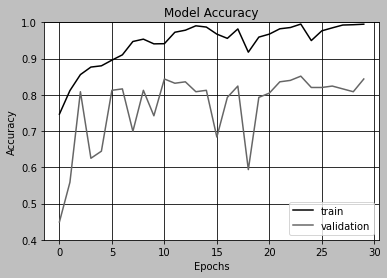

In [ ]:
plt.style.use('grayscale')
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis( ymin= 0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

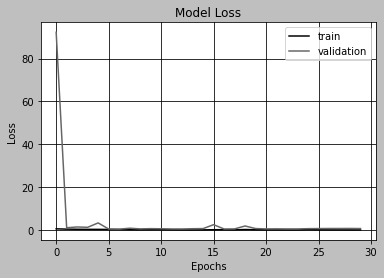

In [ ]:
fig1 = plt.gcf()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['train', 'validation'])
plt.show()
fig1.savefig('loss_plot.jpg')

In [ ]:
Y_pred = model.predict(test_generator)
y_pred=[]
for i in range(len(Y_pred)):
    if Y_pred[i][0]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print('Confusion Matrix')
print(metrics.confusion_matrix(test_generator.classes, y_pred))
print ()

print('Classification Report')
target_names = ['malignan', 'benign']
print(metrics.classification_report(test_generator.classes, y_pred, target_names=target_names))

print(test_generator.class_indices)

Confusion Matrix
[[323  37]
 [ 44 256]]

Classification Report
              precision    recall  f1-score   support

    malignan       0.88      0.90      0.89       360
      benign       0.87      0.85      0.86       300

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.88      0.88      0.88       660

{'benign': 0, 'malignant': 1}


In [ ]:
model.save("E:\\data\\Inception.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: E:\data\Inception.model\assets


# From here test code starts (you can import Real-life Images)

In [ ]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.applications.mobilenet import MobileNet

from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, save_img
from tensorflow.python.keras.layers import Dense, Flatten,MaxPooling2D, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from keras.utils.vis_utils import plot_model
model = tf.keras.models.load_model("E:\\data\\Inception.model")

Using TensorFlow backend.


Found 1 images belonging to 2 classes.
2.3.1
[0]
{'benign': 0, 'malignant': 1}
(224, 224, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

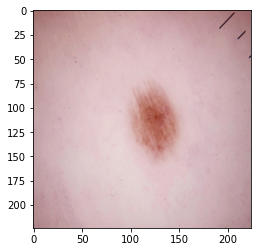

In [ ]:
test2_data_dir='E:\\data\\test2'
img_height= 224
img_width = 224
batch_size= 64
test2_datagen = ImageDataGenerator(rescale=1. / 255)
test2_generator = test2_datagen.flow_from_directory(
        test2_data_dir,  
        target_size=(img_height,img_width), 
        batch_size=batch_size,  
        class_mode='binary',
        shuffle=False)

Y_pred = model.predict(test2_generator)
print(tf.__version__)
y_pred=[]
for i in range(len(Y_pred)):
    if Y_pred[i][0]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print (y_pred)
print(test2_generator.class_indices)
x,y=next(test2_generator)
print(x[0].shape)
plt.imshow(x[0,:,:,:])
plt.show